In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
#ip <- installed.packages() 
#pkgs.to.remove <- ip[!(ip[,"Priority"] %in% c("base", "recommended")), 1]
#sapply(pkgs.to.remove, remove.packages)

NULL


In [3]:
%%R
#source("http://bioconductor.org/biocLite.R")

NULL


In [4]:
%%R
#biocLite("phyloseq")

NULL


In [5]:
%%R
#source("http://bioconductor.org/biocLite.R")
#biocLite("phyloseq")

NULL


In [25]:
%%R
library("phyloseq")
library(ggplot2)

In [200]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [201]:
%%R
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4857 taxa and 66 samples ]
sample_data() Sample Data:       [ 66 samples by 3 sample variables ]
tax_table()   Taxonomy Table:    [ 4857 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4857 tips and 4855 internal nodes ]


In [191]:
%%R
ps.b = subset_taxa(physeq,Kingdom=="Bacteria")
ps.b = subset_samples(ps.b,sample_sums(physeq)>2000)

In [212]:
%%R
physeq.noSmall<-subset_samples(physeq,sample_sums(physeq)>5000)

In [213]:
%%R
ps <- physeq.noSmall

In [214]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [232]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.full = ordinate(ps_snorm, method = "NMDS", distance = "unifrac", weighted=TRUE)
ord.full.plot = plot_ordination(ps_snorm, ord.full, axes = c(1,2), justDF = TRUE)
ord.full.plot$Samples = rownames(ord.full.plot)

Run 0 stress 0.1330348 
Run 1 stress 0.1375593 
Run 2 stress 0.1609782 
Run 3 stress 0.1525336 
Run 4 stress 0.1382973 
Run 5 stress 0.137221 
Run 6 stress 0.1421555 
Run 7 stress 0.1573593 
Run 8 stress 0.151374 
Run 9 stress 0.1423399 
Run 10 stress 0.1326511 
... New best solution
... procrustes: rmse 0.009595974  max resid 0.05708561 
Run 11 stress 0.1408992 
Run 12 stress 0.1555651 
Run 13 stress 0.1326521 
... procrustes: rmse 0.0004199498  max resid 0.00253118 
*** Solution reached


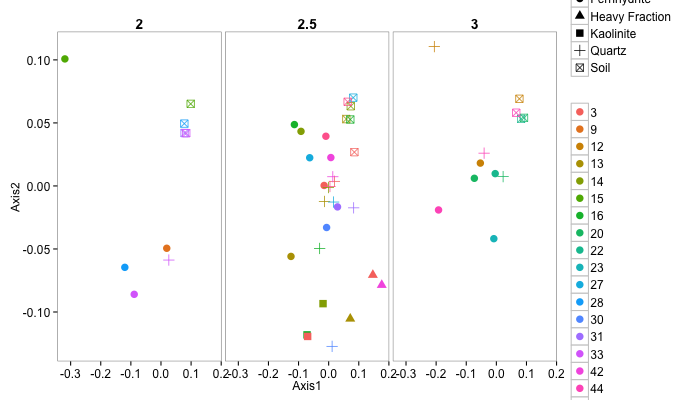

In [233]:
%%R -h 400 -w 700
D <- ord.full.plot
# Sets the relevant ordination

colnames(D)[1:2]<-c("Axis1","Axis2")
# Renames the axis columns

D$Month<-as.factor(D$Month)
D$Cosm<-as.factor(D$Cosm)

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = Axis1, y = Axis2, color = Cosm, shape = Trtmt))

# Determines the size of the symbols
p = p  + geom_point(size=3.5) 
#+ scale_colour_manual(values=c("skyblue3","orange","chartreuse4","gold1","red3","black"))

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days

p

I need to calculate similarity distances between all units and see if the values are closer for related microcosms.  
Need to figure out how to test this